## define functions

In [ ]:
import os, time
import networkx as nx
from pyqubo import Binary
from dwave.samplers import SimulatedAnnealingSampler, TabuSampler
from dwave.system import DWaveSampler, EmbeddingComposite

DATA_DIR = "../dataset"
def load_dimacs(path):
    """讀取 .mis 檔案，回傳 networkx.Graph 與邊清單"""
    edges = []
    with open(path) as f:
        for line in f:
            if line.startswith('e '):
                _, u, v = line.split()
                edges.append((int(u), int(v)))
    G = nx.Graph();  G.add_edges_from(edges)
    return G, edges

def build_qubo(edges, n, lam):
    """以稀疏懲罰 1‑xu‑xv+xu*xv 建 QUBO"""
    x = [Binary(f"x{i}") for i in range(n)]
    idx = {v: i for i, v in enumerate(range(1, n+1))}  # DIMACS 節點從 1 起
    cost = sum(x)                                       # Σ x_i
    penalty = sum(1 - x[idx[u]] - x[idx[v]] + x[idx[u]] * x[idx[v]]
                  for u, v in edges)
    H = cost + lam * penalty
    Q, off = H.compile().to_qubo()
    return Q, off

def greedy_cleanup(sample, edges, n):
    """嘗試刪除冗餘頂點，維持覆蓋合法"""
    cover = {i for i in range(n) if sample[f"x{i}"] == 1}
    adj = [[] for _ in range(n)]
    for u, v in edges:
        adj[u-1].append(v-1); adj[v-1].append(u-1)
    for v in list(cover):
        cover.remove(v)
        if all((e[0]-1 in cover) or (e[1]-1 in cover) for e in edges):
            continue
        cover.add(v)
    return cover

def solve_instance(name, node_num, edge_num, sampler_kind, reads, lam=None, c=None, sweeps=None, timeout=None, beta_range=None, beta_schedule_type=None):
    path = os.path.join(DATA_DIR, name)
    G, edges = load_dimacs(path)
    n = G.number_of_nodes()
    if node_num != n:
        raise ValueError(f"節點數不正確！{node_num} != {n}")
    if len(edges) != edge_num:
        raise ValueError(f"邊數不正確！{len(edges)} != {len(G.edges())}")
    if lam is None:
        lam = (len(edges) / n) * c
    Q, off = build_qubo(edges, n, lam)

    if sampler_kind == "SA":
        sampler = SimulatedAnnealingSampler()
        if beta_range is None and beta_schedule_type is None:
            kwargs = {
                'num_reads': reads,
                'num_sweeps': sweeps or 10000,
            }
        else:
            kwargs = {
                'num_reads': reads,
                'num_sweeps': sweeps or 10000,
                'beta_range': beta_range or [0.01, 20],
                'beta_schedule_type': beta_schedule_type
            }
        if sweeps: kwargs["num_sweeps"] = sweeps
    elif sampler_kind == "QPU":
        sampler = EmbeddingComposite(DWaveSampler())
        kwargs = dict(num_reads=reads) 

    else:
        sampler = TabuSampler()
        kwargs = dict(num_reads=reads, timeout=timeout)

    t0 = time.time()
    result = sampler.sample_qubo(Q, **kwargs)
    best = result.first.sample
    raw_size = sum(best[f"x{i}"] for i in range(n))
    cover = greedy_cleanup(best, edges, n)
    t1 = time.time()
    # free memory
    del G, Q, off, result, best
    return {
        "name": name,
        "reads": reads,
        "sweeps": sweeps,
        "nodes": node_num,
        "edges": edge_num,
        "lam": round(lam, 2),
        "c": c,
        "MVC": len(cover),
        "MVC_raw": raw_size,
        "valid": all((u-1 in cover) or (v-1 in cover) for u, v in edges),
        "time_sec": round(t1 - t0, 1)
    }



## Experiments

### 0. 在量子退火結束之後再過一個 greedy 來做簡單排除篩選，減少數量
* 固定 c = 5 ，而 lambda = |E| / |V| * c ，所以等同固定 lambda
* 固定 sweeps = 100、read = 10 ，不想設定太大不然會跑太久
* 固定不使用 beta 參數
* 變因是有沒有對結果做greedy

In [2]:
config = {
    "keller4.mis": dict(
        node_num=171,
        edge_num=5100,
        # lam=250,
        c=5,
        sampler_kind="SA",
        reads=5,
        sweeps=100,
        # beta_range=[0.01, 20],
        # beta_schedule_type="linear"
    ),
    "keller5.mis": dict(
        node_num=776,
        edge_num=74710,
        # lam=800,
        c=5,
        sampler_kind="SA",
        reads=5,
        sweeps=100,
        # beta_range=[0.01, 20],
        # beta_schedule_type="linear"
    ),
    "keller6.mis": dict(
        node_num=3361,
        edge_num=1026582,
        # lam=1600,
        c=5,
        sampler_kind="SA",
        reads=5,
        sweeps=100,
        # beta_range=[0.01, 20],
        # beta_schedule_type="linear"
    ),
    "p_hat300-1.mis": dict(
        node_num=300,
        edge_num=33917,
        # lam=350,
        c=5,
        sampler_kind="SA",
        reads=5,
        sweeps=100,
        # beta_range=[0.01, 20],
        # beta_schedule_type="linear"
    ),
    "p_hat700-1.mis": dict(
        node_num=700,
        edge_num=183651,
        # lam=700,
        c=5,
        sampler_kind="SA",
        reads=5,
        sweeps=100,
        # beta_range=[0.01, 20],
        # beta_schedule_type="linear"
    ),
    "p_hat1500-1.mis": dict(
        node_num=1500,
        edge_num=839327,
        # lam=1500,
        c=5,
        sampler_kind="SA",
        reads=5,
        sweeps=100,
        # beta_range=[0.01, 20],
        # beta_schedule_type="linear"
    )
}



results = {}
for file, cfg in config.items():
    print(f"\n▶ Solving {file}  …")
    res = solve_instance(file, **cfg)
    results[file] = res
    print(res)

print("\n===== SUMMARY =====")
# markdown table
header = ['name', 'MVC', 'MVC_raw', 'valid', 'time_sec']
print('| ', end='')
for h in header:
    print(f"{h:11s}", end=" | ")
print()
print(f"|{'-------------|'*(len(header))}")
for k,v in results.items():
    # print(f"{k:18s} | size={v['MVC_after_cleanup']:4} | raw={v['MVC_raw']:4} "
    #       f"| valid={v['valid']} | {v['time_sec']}s")
    print(f"| {k:11s}", end=" | ")
    for h in header[1:]:
        if h == 'name':
            v[h] = v[h][0:8]
        print(f"{v[h]:>11}", end=" | ")
    print()
print()
print("===== END =====")
print()
print()


▶ Solving keller4.mis  …
{'name': 'keller4.mis', 'reads': 5, 'sweeps': 100, 'nodes': 171, 'edges': 5100, 'lam': 149.12, 'c': 5, 'MVC': 163, 'MVC_raw': 163, 'valid': True, 'time_sec': 0.0}

▶ Solving keller5.mis  …
{'name': 'keller5.mis', 'reads': 5, 'sweeps': 100, 'nodes': 776, 'edges': 74710, 'lam': 481.38, 'c': 5, 'MVC': 757, 'MVC_raw': 761, 'valid': True, 'time_sec': 0.9}

▶ Solving keller6.mis  …
{'name': 'keller6.mis', 'reads': 5, 'sweeps': 100, 'nodes': 3361, 'edges': 1026582, 'lam': 1527.2, 'c': 5, 'MVC': 3323, 'MVC_raw': 3331, 'valid': True, 'time_sec': 57.1}

▶ Solving p_hat300-1.mis  …
{'name': 'p_hat300-1.mis', 'reads': 5, 'sweeps': 100, 'nodes': 300, 'edges': 33917, 'lam': 565.28, 'c': 5, 'MVC': 294, 'MVC_raw': 295, 'valid': True, 'time_sec': 0.3}

▶ Solving p_hat700-1.mis  …
{'name': 'p_hat700-1.mis', 'reads': 5, 'sweeps': 100, 'nodes': 700, 'edges': 183651, 'lam': 1311.79, 'c': 5, 'MVC': 696, 'MVC_raw': 696, 'valid': True, 'time_sec': 2.3}

▶ Solving p_hat1500-1.mis  …
{

### 1. 調整 reads
* 只針對 keller6 ，因為節點數最多，在我的觀察下是最不穩定的一個
  * 固定 c = 5 ，而 lambda = |E| / |V| * c ，所以等同固定 lambda
  * 固定 sweeps = 1000 ，不想設定太大不然會跑太久
  * 固定 beta_range=[0.01, 20]
  * 固定 beta_schedule_type="linear"
  * reads = [1, 5, 10, 100, 500, 1000, 5000, 10000]

In [ ]:
config = {
    "1": dict( node_num=3361, edge_num=1026582, c=5, sampler_kind="SA", reads=1, sweeps=100, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "5": dict( node_num=3361, edge_num=1026582, c=5, sampler_kind="SA", reads=5, sweeps=100, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "10": dict( node_num=3361, edge_num=1026582, c=5, sampler_kind="SA", reads=10, sweeps=100, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "100": dict( node_num=3361, edge_num=1026582, c=5, sampler_kind="SA", reads=100, sweeps=100, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "500": dict( node_num=3361, edge_num=1026582, c=5, sampler_kind="SA", reads=150, sweeps=100, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "1000": dict( node_num=3361, edge_num=1026582, c=5, sampler_kind="SA", reads=1000, sweeps=100, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "5000": dict( node_num=3361, edge_num=1026582, c=5, sampler_kind="SA", reads=5000, sweeps=100, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "10000": dict( node_num=3361, edge_num=1026582, c=5, sampler_kind="SA", reads=10000, sweeps=100, beta_range=[0.01, 20], beta_schedule_type="linear"),

}

results = {}
for file, cfg in config.items():
    
    print(f"▶ Solving {file}  …")
    res = solve_instance('keller6.mis', **cfg)
    results[file] = res
    print(res)
    # FREE MEMORY
    del res
    del cfg

print("===== SUMMARY =====")
# markdown table
header = ['name', 'reads', 'MVC', 'MVC_raw', 'valid', 'time_sec']
print('| ', end='')
for h in header:
    print(f"{h:11s}", end=" | ")
print()
print(f"|{'-------------|'*(len(header))}")
for k,v in results.items():
    # print(f"{k:18s} | size={v['MVC_after_cleanup']:4} | raw={v['MVC_raw']:4} "
    #       f"| valid={v['valid']} | {v['time_sec']}s")
    print(f"| {k:11s}", end=" | ")
    for h in header[1:]:
        if h == 'name':
            v[h] = v[h][0:8]
        print(f"{v[h]:>11}", end=" | ")
    print()
print("===== END =====")

▶ Solving 1  …
{'name': 'keller6.mis', 'reads': 1, 'sweeps': 100, 'nodes': 3361, 'edges': 1026582, 'lam': 1527.2, 'c': 5, 'MVC': 3323, 'MVC_raw': 3323, 'valid': True, 'time_sec': 42.6}
▶ Solving 5  …
{'name': 'keller6.mis', 'reads': 5, 'sweeps': 100, 'nodes': 3361, 'edges': 1026582, 'lam': 1527.2, 'c': 5, 'MVC': 3318, 'MVC_raw': 3318, 'valid': True, 'time_sec': 47.1}
▶ Solving 10  …
{'name': 'keller6.mis', 'reads': 10, 'sweeps': 100, 'nodes': 3361, 'edges': 1026582, 'lam': 1527.2, 'c': 5, 'MVC': 3319, 'MVC_raw': 3319, 'valid': True, 'time_sec': 48.1}
▶ Solving 100  …
{'name': 'keller6.mis', 'reads': 100, 'sweeps': 100, 'nodes': 3361, 'edges': 1026582, 'lam': 1527.2, 'c': 5, 'MVC': 3314, 'MVC_raw': 3314, 'valid': True, 'time_sec': 74.0}
▶ Solving 500  …
{'name': 'keller6.mis', 'reads': 150, 'sweeps': 100, 'nodes': 3361, 'edges': 1026582, 'lam': 1527.2, 'c': 5, 'MVC': 3317, 'MVC_raw': 3317, 'valid': True, 'time_sec': 60.5}
▶ Solving 1000  …
{'name': 'keller6.mis', 'reads': 1000, 'sweeps'

### 2. 調整 sweeps
* 只對 keller4 ，因為節點數最多，在我的觀察下是最不穩定的一個
  * 固定 c = 5 ，而 lambda = |E| / |V| * c ，所以等同固定 lambda
  * 固定 reads = 100 ，不想設定太大不然會跑太久
  * 固定 beta_range=[0.01, 20]
  * 固定 beta_schedule_type="linear"
  * sweeps = [1, 5, 10, 100, 500, 1000, 5000, 10000]

In [ ]:
config = {
    "1": dict( node_num=171, edge_num=5100, c=5, sampler_kind="SA", reads=100, sweeps=1, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "5": dict( node_num=171, edge_num=5100, c=5, sampler_kind="SA", reads=100, sweeps=5, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "10": dict( node_num=171, edge_num=5100, c=5, sampler_kind="SA", reads=100, sweeps=10, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "100": dict( node_num=171, edge_num=5100, c=5, sampler_kind="SA", reads=100, sweeps=100, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "500": dict( node_num=171, edge_num=5100, c=5, sampler_kind="SA", reads=100, sweeps=500, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "1000": dict( node_num=171, edge_num=5100, c=5, sampler_kind="SA", reads=100, sweeps=1000, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "5000": dict( node_num=171, edge_num=5100, c=5, sampler_kind="SA", reads=100, sweeps=5000, beta_range=[0.01, 20], beta_schedule_type="linear"),
    "10000": dict( node_num=171, edge_num=5100, c=5, sampler_kind="SA", reads=100, sweeps=10000, beta_range=[0.01, 20], beta_schedule_type="linear"),
}

results = {}
for file, cfg in config.items():
    
    print(f"▶ Solving {file}  …")
    res = solve_instance('keller4.mis', **cfg)
    results[file] = res
    print(res)
    # FREE MEMORY
    del res
    del cfg

print("===== SUMMARY =====")
# markdown table
header = ['sweeps', 'MVC', 'MVC_raw', 'valid', 'time_sec']
print('| ', end='')
for h in header:
    print(f"{h:11s}", end=" | ")
print()
print(f"|{'-------------|'*(len(header))}")
for k,v in results.items():
    # print(f"{k:18s} | size={v['MVC_after_cleanup']:4} | raw={v['MVC_raw']:4} "
    #       f"| valid={v['valid']} | {v['time_sec']}s")
    print(f"| {k:11s}", end=" | ")
    for h in header[1:]:
        if h == 'name':
            v[h] = v[h][0:8]
        print(f"{v[h]:>11}", end=" | ")
    print()
print("===== END =====")

▶ Solving 1  …
{'name': 'keller4.mis', 'reads': 100, 'sweeps': 1, 'nodes': 171, 'edges': 5100, 'lam': 149.12, 'c': 5, 'MVC': 164, 'MVC_raw': 166, 'valid': True, 'time_sec': 0.0}
▶ Solving 5  …
{'name': 'keller4.mis', 'reads': 100, 'sweeps': 5, 'nodes': 171, 'edges': 5100, 'lam': 149.12, 'c': 5, 'MVC': 162, 'MVC_raw': 162, 'valid': True, 'time_sec': 0.0}
▶ Solving 10  …
{'name': 'keller4.mis', 'reads': 100, 'sweeps': 10, 'nodes': 171, 'edges': 5100, 'lam': 149.12, 'c': 5, 'MVC': 162, 'MVC_raw': 162, 'valid': True, 'time_sec': 0.0}
▶ Solving 100  …
{'name': 'keller4.mis', 'reads': 100, 'sweeps': 100, 'nodes': 171, 'edges': 5100, 'lam': 149.12, 'c': 5, 'MVC': 160, 'MVC_raw': 160, 'valid': True, 'time_sec': 0.0}
▶ Solving 500  …
{'name': 'keller4.mis', 'reads': 100, 'sweeps': 500, 'nodes': 171, 'edges': 5100, 'lam': 149.12, 'c': 5, 'MVC': 160, 'MVC_raw': 160, 'valid': True, 'time_sec': 0.0}
▶ Solving 1000  …
{'name': 'keller4.mis', 'reads': 100, 'sweeps': 1000, 'nodes': 171, 'edges': 5100,

### 3. 加入 beta_range & beta_schedule_type
* 只針對 keller5
* 固定 c = 5 ，而 lambda = |E| / |V| * c ，所以等同固定 lambda
* 固定 reads = 1000 ，sweeps=2000
* 比較 
  1. beta_range=[0.01, 20], beta_schedule_type="linear"
  2. beta_range=[0.01, 20], beta_schedule_type="geometric"
  3. 都沒有

In [ ]:
config = {
    "geometric + beta_range=[0.01, 20]": dict(
        node_num=776,
        edge_num=74710,
        # lam=800,
        c=5,
        sampler_kind="SA",
        reads=1000,
        sweeps=2000,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    ),
    "linear + beta_range=[0.01, 20]": dict(
        node_num=776,
        edge_num=74710,
        # lam=800,
        c=5,
        sampler_kind="SA",
        reads=1000,
        sweeps=2000,
        beta_range=[0.01, 20],
        beta_schedule_type="geometric"
    ),
    "neither": dict(
        node_num=776,
        edge_num=74710,
        # lam=800,
        c=5,
        sampler_kind="SA",
        reads=1000,
        sweeps=2000,
        # beta_range=[0.01, 20],
        # beta_schedule_type="linear"
    ),
}

results = {}
for file, cfg in config.items():
    
    print(f"▶ Solving {file}  …")
    res = solve_instance('keller5.mis', **cfg)
    results[file] = res
    print(res)
    # FREE MEMORY
    del res
    del cfg

print("===== SUMMARY =====")
# markdown table
header = ['method', 'MVC', 'MVC_raw', 'valid', 'time_sec']
print('| ', end='')
for h in header:
    print(f"{h:11s}", end=" | ")
print()
print(f"|{'-------------|'*(len(header))}")
for k,v in results.items():
    # print(f"{k:18s} | size={v['MVC_after_cleanup']:4} | raw={v['MVC_raw']:4} "
    #       f"| valid={v['valid']} | {v['time_sec']}s")
    print(f"| {k:11s}", end=" | ")
    for h in header[1:]:
        if h == 'name':
            v[h] = v[h][0:8]
        print(f"{v[h]:>11}", end=" | ")
    print()
print("===== END =====")

▶ Solving geometric + beta_range=[0.01, 20]  …
{'name': 'keller5.mis', 'reads': 1000, 'sweeps': 2000, 'nodes': 776, 'edges': 74710, 'lam': 481.38, 'c': 5, 'MVC': 749, 'MVC_raw': 749, 'valid': True, 'time_sec': 2.9}
▶ Solving linear + beta_range=[0.01, 20]  …
{'name': 'keller5.mis', 'reads': 1000, 'sweeps': 2000, 'nodes': 776, 'edges': 74710, 'lam': 481.38, 'c': 5, 'MVC': 749, 'MVC_raw': 749, 'valid': True, 'time_sec': 8.8}
▶ Solving neither  …
{'name': 'keller5.mis', 'reads': 1000, 'sweeps': 2000, 'nodes': 776, 'edges': 74710, 'lam': 481.38, 'c': 5, 'MVC': 757, 'MVC_raw': 758, 'valid': True, 'time_sec': 67.0}
===== SUMMARY =====
| method      | MVC         | MVC_raw     | valid       | time_sec    | 
|-------------|-------------|-------------|-------------|-------------|
| geometric + beta_range=[0.01, 20] |         749 |         749 |           1 |         2.9 | 
| linear + beta_range=[0.01, 20] |         749 |         749 |           1 |         8.8 | 
| neither     |         757 |  

### 4. 調整 $\lambda$
* 針對 keller4、keller5、p_hat300‑1、p_hat700‑1 資料集做實驗，因為邊數相對較小
* 固定 read=100, sweep=1000, 不使用 beta 參數
* $\lambda$ = [1, 10, 50, 100, 200, 300, 400, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000]

#### 4-1 keller4

In [ ]:
node_num = 171
edge_num = 5100
reads = 100
sweeps = 1000
sampler_kind = "SA"
dataset = "keller4.mis"
lambda_list = [1, 10, 50, 100, 200, 300, 400, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000]

config = {
    f"lam_{lam}": dict(
        node_num=node_num,
        edge_num=edge_num,
        lam=lam,
        sampler_kind=sampler_kind,
        reads=reads,
        sweeps=sweeps
    )
    for lam in lambda_list
}

results = {}
for file, cfg in config.items():
    
    print(f"▶ Solving {file}  …")
    res = solve_instance(dataset, **cfg)
    results[file] = res
    print(res)
    # FREE MEMORY
    del res
    del cfg

print("===== SUMMARY =====")
# markdown table
header = ['sweeps', 'MVC', 'MVC_raw', 'valid', 'time_sec']
print('| ', end='')
for h in header:
    print(f"{h:11s}", end=" | ")
print()
print(f"|{'-------------|'*(len(header))}")
for k,v in results.items():
    # print(f"{k:18s} | size={v['MVC_after_cleanup']:4} | raw={v['MVC_raw']:4} "
    #       f"| valid={v['valid']} | {v['time_sec']}s")
    print(f"| {k:11s}", end=" | ")
    for h in header[1:]:
        if h == 'name':
            v[h] = v[h][0:8]
        print(f"{v[h]:>11}", end=" | ")
    print()
print("===== END =====")

▶ Solving lam_1  …
{'name': 'keller4.mis', 'reads': 100, 'sweeps': 1000, 'nodes': 171, 'edges': 5100, 'lam': 1, 'c': None, 'MVC': 159, 'MVC_raw': 159, 'valid': False, 'time_sec': 0.4}
▶ Solving lam_10  …
{'name': 'keller4.mis', 'reads': 100, 'sweeps': 1000, 'nodes': 171, 'edges': 5100, 'lam': 10, 'c': None, 'MVC': 160, 'MVC_raw': 160, 'valid': True, 'time_sec': 0.4}
▶ Solving lam_50  …
{'name': 'keller4.mis', 'reads': 100, 'sweeps': 1000, 'nodes': 171, 'edges': 5100, 'lam': 50, 'c': None, 'MVC': 162, 'MVC_raw': 162, 'valid': True, 'time_sec': 0.4}
▶ Solving lam_100  …
{'name': 'keller4.mis', 'reads': 100, 'sweeps': 1000, 'nodes': 171, 'edges': 5100, 'lam': 100, 'c': None, 'MVC': 161, 'MVC_raw': 162, 'valid': True, 'time_sec': 0.4}
▶ Solving lam_200  …
{'name': 'keller4.mis', 'reads': 100, 'sweeps': 1000, 'nodes': 171, 'edges': 5100, 'lam': 200, 'c': None, 'MVC': 162, 'MVC_raw': 162, 'valid': True, 'time_sec': 0.4}
▶ Solving lam_300  …
{'name': 'keller4.mis', 'reads': 100, 'sweeps': 100

### 4-2 keller5

In [9]:
node_num = 776
edge_num = 74710
reads = 100
sweeps = 1000
sampler_kind = "SA"
dataset = "keller5.mis"
lambda_list = [1, 10, 50, 100, 200, 300, 400, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000]

config = {
    f"lam_{lam}": dict(
        node_num=node_num,
        edge_num=edge_num,
        lam=lam,
        sampler_kind=sampler_kind,
        reads=reads,
        sweeps=sweeps
    )
    for lam in lambda_list
}

results = {}
for file, cfg in config.items():
    
    print(f"▶ Solving {file}  …")
    res = solve_instance(dataset, **cfg)
    results[file] = res
    print(res)
    # FREE MEMORY
    del res
    del cfg

print("===== SUMMARY =====")
# markdown table
header = ['$\lambda$', 'MVC', 'MVC_raw', 'valid', 'time_sec']
print('| ', end='')
for h in header:
    print(f"{h:11s}", end=" | ")
print()
print(f"|{'-------------|'*(len(header))}")
for k,v in results.items():
    # print(f"{k:18s} | size={v['MVC_after_cleanup']:4} | raw={v['MVC_raw']:4} "
    #       f"| valid={v['valid']} | {v['time_sec']}s")
    print(f"| {k:11s}", end=" | ")
    for h in header[1:]:
        if h == 'name':
            v[h] = v[h][0:8]
        print(f"{v[h]:>11}", end=" | ")
    print()
print("===== END =====")

▶ Solving lam_1  …
{'name': 'keller5.mis', 'reads': 100, 'sweeps': 1000, 'nodes': 776, 'edges': 74710, 'lam': 1, 'c': None, 'MVC': 747, 'MVC_raw': 747, 'valid': False, 'time_sec': 3.9}
▶ Solving lam_10  …
{'name': 'keller5.mis', 'reads': 100, 'sweeps': 1000, 'nodes': 776, 'edges': 74710, 'lam': 10, 'c': None, 'MVC': 753, 'MVC_raw': 754, 'valid': True, 'time_sec': 4.1}
▶ Solving lam_50  …
{'name': 'keller5.mis', 'reads': 100, 'sweeps': 1000, 'nodes': 776, 'edges': 74710, 'lam': 50, 'c': None, 'MVC': 756, 'MVC_raw': 758, 'valid': True, 'time_sec': 4.9}
▶ Solving lam_100  …
{'name': 'keller5.mis', 'reads': 100, 'sweeps': 1000, 'nodes': 776, 'edges': 74710, 'lam': 100, 'c': None, 'MVC': 757, 'MVC_raw': 758, 'valid': True, 'time_sec': 4.3}
▶ Solving lam_200  …
{'name': 'keller5.mis', 'reads': 100, 'sweeps': 1000, 'nodes': 776, 'edges': 74710, 'lam': 200, 'c': None, 'MVC': 758, 'MVC_raw': 759, 'valid': True, 'time_sec': 4.6}
▶ Solving lam_300  …
{'name': 'keller5.mis', 'reads': 100, 'sweeps'

### 5. 奇妙的實驗: 答案分布圖
* 鑒於套件限制，我們每一次去跑一個資料集的時候都只能在一開始訂好 read 數量(假設=10000)，並且過程是不可見的，最終只會輸出那 10000 次 read 的最佳解，而我想看看每一次read 分別的解，所以把 read 設定成 1 然後去跑，繪出機率分布圖
* 用 keller 5
  * 固定 c = 5 ，而 lambda = |E| / |V| * c ，所以等同固定 lambda
  * 固定 reads = 1, sweeps = 1000
  * 固定 beta_range=[0.01, 20]
  * 固定 beta_schedule_type="linear"
  * 總共跑1000次

In [ ]:
node_num = 776
edge_num = 74710
# edge_num = 5100
reads = 1
sweeps = 1000
sampler_kind = "SA"
dataset = "keller5.mis"

config = {
    f"{r}": dict(
        node_num=node_num,
        edge_num=edge_num,
        c=5,
        sampler_kind=sampler_kind,
        reads=1,
        sweeps=sweeps,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    )
    for r in range(175)
}
from tqdm import tqdm
results = {}
for file, cfg in tqdm(config.items()):
    
    # print(f"▶ Solving {file}  …")
    res = solve_instance(dataset, **cfg)
    results[file] = res
    # print(res)
    # FREE MEMORY
    del res
    del cfg







100%|██████████| 175/175 [05:33<00:00,  1.91s/it]


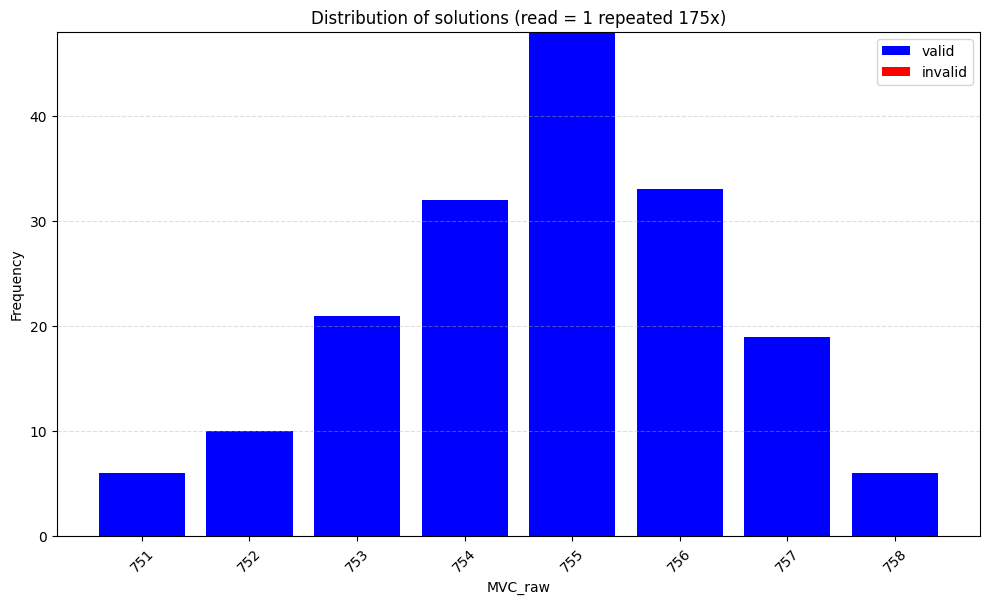

In [3]:
import matplotlib.pyplot as plt
from collections import defaultdict

# 統計合法與非法解的出現次數
valid_counter = defaultdict(int)
invalid_counter = defaultdict(int)

for r_id, result in results.items():
    mvc = result["MVC_raw"]
    if result["valid"]:
        valid_counter[mvc] += 1
    else:
        invalid_counter[mvc] += 1

# 所有出現過的 MVC 值
mvc_values = sorted(set(valid_counter) | set(invalid_counter))
valid_counts = [valid_counter[mvc] for mvc in mvc_values]
invalid_counts = [invalid_counter[mvc] for mvc in mvc_values]

# 繪圖
plt.figure(figsize=(10, 6))
plt.bar(mvc_values, valid_counts, color='blue', label='valid')
plt.bar(mvc_values, invalid_counts, bottom=valid_counts, color='red', label='invalid')

plt.xlabel("MVC_raw")
plt.ylabel("Frequency")
plt.title("Distribution of solutions (read = 1 repeated 175x)")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(mvc_values, rotation=45)
plt.show()

## best results

In [3]:
config = {
    "keller4.mis": dict(
        node_num=171,
        edge_num=5100,
        # lam=250,
        c=5,
        sampler_kind="SA",
        reads=2000,
        sweeps=1000,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    ),
    "keller5.mis": dict(
        node_num=776,
        edge_num=74710,
        # lam=800,
        c=5,
        sampler_kind="SA",
        reads=2000,
        sweeps=2000,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    ),
    "keller6.mis": dict(
        node_num=3361,
        edge_num=1026582,
        # lam=1600,
        c=5,
        sampler_kind="SA",
        reads=5000,
        sweeps=5000,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    ),
    "p_hat300-1.mis": dict(
        node_num=300,
        edge_num=33917,
        # lam=350,
        c=5,
        sampler_kind="SA",
        reads=1000,
        sweeps=2500,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    ),
    "p_hat700-1.mis": dict(
        node_num=700,
        edge_num=183651,
        # lam=700,
        c=5,
        sampler_kind="SA",
        reads=1000,
        sweeps=4000,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    ),
    "p_hat1500-1.mis": dict(
        node_num=1500,
        edge_num=839327,
        # lam=1500,
        c=5,
        sampler_kind="SA",
        reads=1000,
        sweeps=6000,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    )
}



results = {}
for file, cfg in config.items():
    print(f"\n▶ Solving {file}  …")
    res = solve_instance(file, **cfg)
    results[file] = res
    print(res)

print("\n===== SUMMARY =====")
# markdown table
header = ['name', 'MVC', 'reads', 'sweeps', 'nodes', 'edges', 'lam', 'c', 'MVC_raw', 'valid', 'time_sec']
print('| ', end='')
for h in header:
    print(f"{h:11s}", end=" | ")
print()
print(f"|{'-------------|'*(len(header))}")
for k,v in results.items():
    # print(f"{k:18s} | size={v['MVC_after_cleanup']:4} | raw={v['MVC_raw']:4} "
    #       f"| valid={v['valid']} | {v['time_sec']}s")
    print(f"| {k:11s}", end=" | ")
    for h in header[1:]:
        if h == 'name':
            v[h] = v[h][0:8]
        print(f"{v[h]:>11}", end=" | ")
    print()
print()
print("===== END =====")
print()
print()


▶ Solving keller4.mis  …
{'name': 'keller4.mis', 'reads': 2000, 'sweeps': 1000, 'nodes': 171, 'edges': 5100, 'lam': 149.12, 'c': 5, 'MVC': 160, 'MVC_raw': 160, 'valid': True, 'time_sec': 0.7}

▶ Solving keller5.mis  …
{'name': 'keller5.mis', 'reads': 2000, 'sweeps': 2000, 'nodes': 776, 'edges': 74710, 'lam': 481.38, 'c': 5, 'MVC': 749, 'MVC_raw': 749, 'valid': True, 'time_sec': 6.2}

▶ Solving keller6.mis  …
{'name': 'keller6.mis', 'reads': 5000, 'sweeps': 5000, 'nodes': 3361, 'edges': 1026582, 'lam': 1527.2, 'c': 5, 'MVC': 3307, 'MVC_raw': 3307, 'valid': True, 'time_sec': 234.1}

▶ Solving p_hat300-1.mis  …
{'name': 'p_hat300-1.mis', 'reads': 1000, 'sweeps': 2500, 'nodes': 300, 'edges': 33917, 'lam': 565.28, 'c': 5, 'MVC': 292, 'MVC_raw': 292, 'valid': True, 'time_sec': 1.2}

▶ Solving p_hat700-1.mis  …
{'name': 'p_hat700-1.mis', 'reads': 1000, 'sweeps': 4000, 'nodes': 700, 'edges': 183651, 'lam': 1311.79, 'c': 5, 'MVC': 689, 'MVC_raw': 689, 'valid': True, 'time_sec': 5.8}

▶ Solving